

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=15,
    # randomly shift images horizontally
    width_shift_range=0.05,
    # randomly shift images vertically
    height_shift_range=0.05,
    # randomly flip images
    horizontal_flip=False,
    # randomly flip images
    vertical_flip=False
)    


output_path = os.path.abspath('./output')
data_name = 'mnist'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(60000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.4, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.2, 'epochs':120}, 
        'custom':{'dropout':0.3, 'epochs':120},
        'vgg':{'dropout':0.4, 'epochs':120},
        'resnet':{'epochs':120}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2021-08-10 08:28:52,753: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json


### 下载数据

开始下载数据。

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

# 增加一个通道
train_images = np.expand_dims(train_images, axis=-1) 
test_images = np.expand_dims(test_images, axis=-1) 


print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)




### 查看数据

下面看一看实际的数据是啥样的。

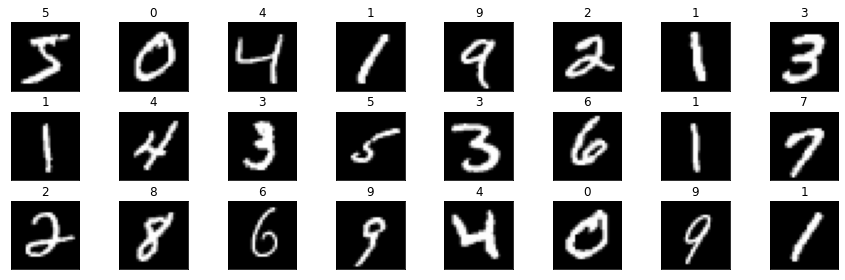

In [5]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

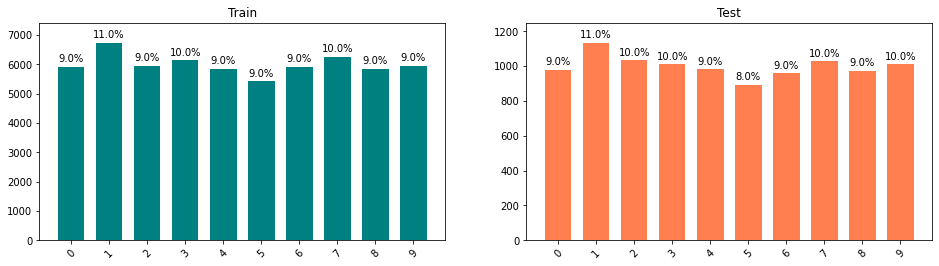

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [7]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [8]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [9]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

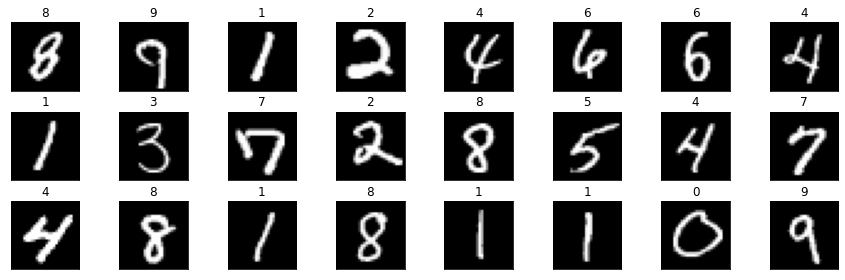

In [10]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [11]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

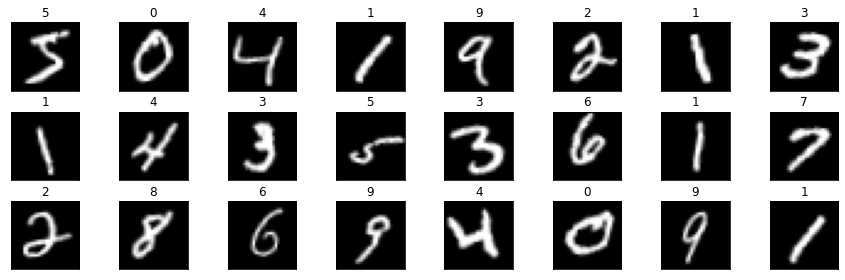

In [12]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

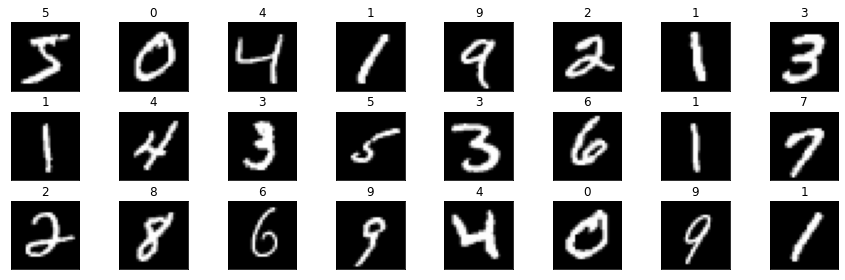

In [13]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [14]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [15]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


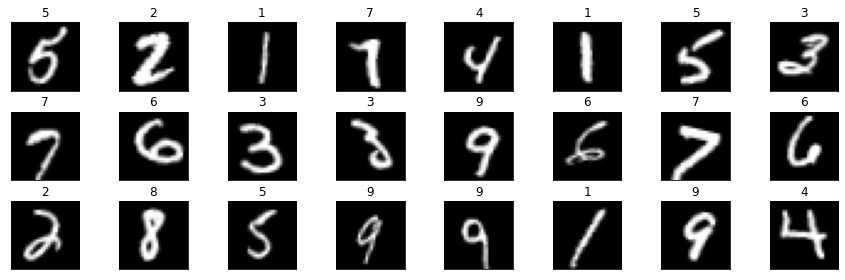

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

2021-08-10 08:29:03,298: INFO: model_params.mlp1.dropout=0.4
2021-08-10 08:29:03,299: INFO: model_params.mlp1.layer_count=1
2021-08-10 08:29:03,300: INFO: model_params.mlp1.units=128
2021-08-10 08:29:03,369: INFO: learning_rate=0.001
2021-08-10 08:29:03,370: INFO: model_params.mlp1.clip_value=None
2021-08-10 08:29:03,392: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1
2021-08-10 08:29:03,395: INFO: model_params.mlp1.epochs=120
2021-08-10 08:29:03,395: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1, monitor=val_accuracy)
2021-08-10 08:29:03,396: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:29:03,397: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:29:03,398: INFO: use LearningRateScheduler()
2021-08-10 08:29:03,398: INF

TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)
Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
1875/1875 [==============================] - 5s

2021-08-10 08:29:09,669: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 2/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1875 - accuracy: 0.9456 - val_loss: 0.1115 - val_accuracy: 0.9659
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:14,472: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 3/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1496 - accuracy: 0.9555 - val_loss: 0.1021 - val_accuracy: 0.9687
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:19,188: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 4/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1288 - accuracy: 0.9615 - val_loss: 0.0920 - val_accuracy: 0.9726
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:23,885: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 5/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1164 - accuracy: 0.9642 - val_loss: 0.0877 - val_accuracy: 0.9733
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:28,637: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 6/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1076 - accuracy: 0.9664 - val_loss: 0.0845 - val_accuracy: 0.9760
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:33,309: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 7/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0985 - accuracy: 0.9687 - val_loss: 0.0805 - val_accuracy: 0.9771
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:37,985: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 8/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0921 - accuracy: 0.9706 - val_loss: 0.0793 - val_accuracy: 0.9792
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:29:42,368: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 9/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0901 - accuracy: 0.9715 - val_loss: 0.0828 - val_accuracy: 0.9772
Epoch 10/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0849 - accuracy: 0.9728 - val_loss: 0.0773 - val_accuracy: 0.9784
Epoch 11/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0814 - accuracy: 0.9742 - val_loss: 0.0808 - val_accuracy: 0.9780
Epoch 12/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0781 - accuracy: 0.9750 - val_loss: 0.0821 - val_accuracy: 0.9788
Epoch 13/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0728 - accuracy: 0.9763 - val_loss: 0.0783 - val_accuracy: 0.9784
Epoch 14/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0694 - accuracy: 0.9773 - val_loss: 0.0835 - val_accuracy: 0.9788
Epoch 15/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0683 - accuracy: 0.9777 - val_loss: 0.0840 - 

2021-08-10 08:30:13,669: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 17/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0658 - accuracy: 0.9781 - val_loss: 0.0861 - val_accuracy: 0.9791
Epoch 18/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0658 - accuracy: 0.9783 - val_loss: 0.0853 - val_accuracy: 0.9787
Epoch 19/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0628 - accuracy: 0.9786 - val_loss: 0.0829 - val_accuracy: 0.9798
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:30:25,768: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 20/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0605 - accuracy: 0.9798 - val_loss: 0.0834 - val_accuracy: 0.9784
Epoch 21/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0588 - accuracy: 0.9808 - val_loss: 0.0871 - val_accuracy: 0.9793
Epoch 22/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0583 - accuracy: 0.9802 - val_loss: 0.0875 - val_accuracy: 0.9790
Epoch 23/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0570 - accuracy: 0.9813 - val_loss: 0.0889 - val_accuracy: 0.9783
Epoch 24/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0568 - accuracy: 0.9814 - val_loss: 0.0887 - val_accuracy: 0.9801
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:30:45,096: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 25/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0513 - accuracy: 0.9825 - val_loss: 0.0941 - val_accuracy: 0.9793

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
Epoch 26/120
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0431 - accuracy: 0.9858 - val_loss: 0.0851 - val_accuracy: 0.9808
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:30:53,459: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 27/120
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0404 - accuracy: 0.9862 - val_loss: 0.0820 - val_accuracy: 0.9811
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:30:57,884: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 28/120
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0371 - accuracy: 0.9875 - val_loss: 0.0856 - val_accuracy: 0.9814
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:31:02,310: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 29/120
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0359 - accuracy: 0.9879 - val_loss: 0.0829 - val_accuracy: 0.9823
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 08:31:06,877: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 30/120
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0348 - accuracy: 0.9882 - val_loss: 0.0861 - val_accuracy: 0.9812
Epoch 31/120
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0345 - accuracy: 0.9883 - val_loss: 0.0843 - val_accuracy: 0.9818
Epoch 32/120
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0328 - accuracy: 0.9888 - val_loss: 0.0867 - val_accuracy: 0.9814
Epoch 33/120
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0326 - accuracy: 0.9892 - val_loss: 0.0847 - val_accuracy: 0.9820
Epoch 34/120
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0336 - accu

2021-08-10 08:31:30,537: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 36/120
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0331 - accuracy: 0.9889 - val_loss: 0.0879 - val_accuracy: 0.9821
Epoch 37/120
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0313 - accuracy: 0.9900 - val_loss: 0.0907 - val_accuracy: 0.9801
Epoch 38/120
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0303 - accuracy: 0.9893 - val_loss: 0.0864 - val_accuracy: 0.9819
Epoch 39/120
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0303 - accuracy: 0.9893 - val_loss: 0.0864 - val_accuracy: 0.9818
Epoch 40/120
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0299 - accu

2021-08-10 08:32:33,070: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 52/120
Epoch 00052: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0248 - accuracy: 0.9915 - val_loss: 0.0888 - val_accuracy: 0.9826
Epoch 53/120
Epoch 00053: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0234 - accuracy: 0.9920 - val_loss: 0.0895 - val_accuracy: 0.9826
Epoch 54/120
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0245 - accuracy: 0.9917 - val_loss: 0.0907 - val_accuracy: 0.9823
Epoch 55/120
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0235 - accuracy: 0.9922 - val_loss: 0.0902 - val_accuracy: 0.9817

Epoch 00055: ReduceLROnPlateau reducing learning rate to 3.1622778103685084e-05.
Epoch 56/120
Epoch 00056: LearningRateScheduler reducing learning rate to 0.001 from 3




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [ ]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

In [ ]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [ ]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

In [ ]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

In [ ]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [ ]:
type(helper.datasets.train_dataset)